In [44]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


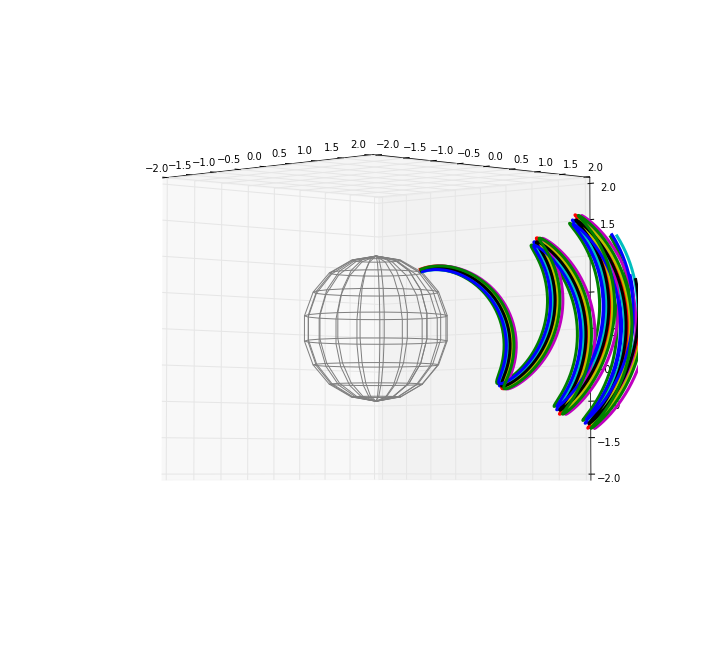

(-2, 2)

In [52]:
# ----- Plot rays (3d version) -----

# Load rayfile:
# rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/raytest4/ray_200.ray')
rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/fl_ngo_dipole/',200, 40, 42, -2,2)


flashtime = dt.datetime(2010, 6, 4, 7, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

psize = 2
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)

#     derp = tmp_coords[0]
#     derp = derp.convert('MAG','sph')
#     print derp
    

# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=3)

ax.set_xlim([-psize, psize])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])






['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']


<IPython.core.display.Javascript object>


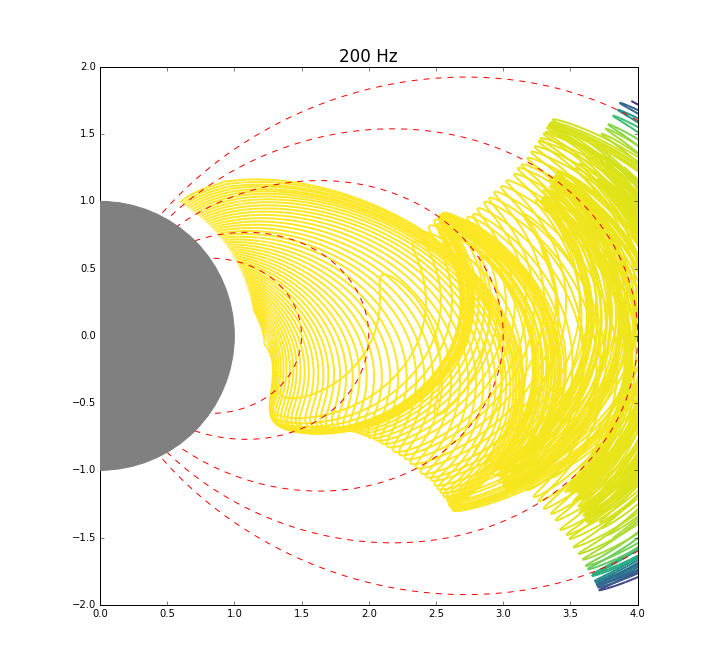

In [51]:
from matplotlib import collections  as mc
# freqs = [200, 300, 400, 500, 600, 1000, 30000]
f1 = 200; f2 = 30000;
num_freqs = 33
flogs = np.linspace(np.log10(f1), np.log10(f2), num_freqs)
freqs = np.round(pow(10, flogs)/10.)*10

flashtime = dt.datetime(2010, 6, 4, 7, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

rootdir = '/shared/users/asousa/WIPP/3dWIPP/outputs/fl_ngo_igrf2/'
for f in freqs[0:1]:
    # rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/rays/ray_200_40_0.ray')
    # rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/freespace/',200, 0, 60, 0,0)
    rf = read_rayfiles(rootdir,f, 0, 90, 0,0)

    # Convert to geographic coordinates for plotting:
    rays = []
    pwr  = []
    print rf[0].keys()

    D2R = np.pi/180.
    L_shells = [1.5, 2, 3, 4, 5]
    # -------- 2D Plot -------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    psize = 4

    # Plot the earth
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    ax.add_patch(earth)                    # The earth (round)

    # Plot the fieldlines
    for L in L_shells:
        lam = np.linspace(-80,80,181)
        L_r = L*pow(np.cos(lam*D2R),2)
        Lx  = L_r*np.cos(lam*D2R)
        Ly  = L_r*np.sin(lam*D2R)
        ax.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line





    for r in rf:

        tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
        tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
        tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks

        tmp_coords = tmp_coords.convert('MAG','car')
        tmp_coords.sim_time = r['time']

        tmp_coords.pwr = r['damping']

#         print r['stopcond']
        rays.append(tmp_coords)
    #     # calc propagation angle to B0:
    #     dd = r['pos'].iloc[0,:]
    #     bb = r['B0'].iloc[0,:]

    # #     print np.asarray(dd/np.linalg.norm(dd)), np.asarray(bb/np.linalg.norm(bb))

    # #     tb = (180./np.pi)*np.dot(dd, bb)/np.linalg.norm(dd)/np.linalg.norm(bb)
    # # #     print dd, bb
    # #     print tb
    if r['stopcond'] != 0:
        print r['stopcond'] 
    #     print np.linalg.norm(r['vgrel'].iloc[0,:])
    #     print np.linalg.norm(r['n'].iloc[0,:])
    #     print '---'
    # #     print np.linalg.norm(r['pos'].iloc[0])



    # Plot rays:
    for r in rays:
#         ax.plot(np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E, linewidth=1, color='b')# marker='.')
    #     # This block to map damping to color:
        C = plt.cm.viridis(r.pwr)
        points = np.array([np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mc.LineCollection(segments, colors=C,alpha=1,linewidth=2)
        ax.add_collection(lc)



        ax.set_xlim([0, psize])
        ax.set_ylim([-psize/2.0, psize/2.0])

    ax.set_title('%d Hz'%f)
    
    plt.savefig(os.path.join(rootdir, 'rays_%dHz.png'%f))

<IPython.core.display.Javascript object>


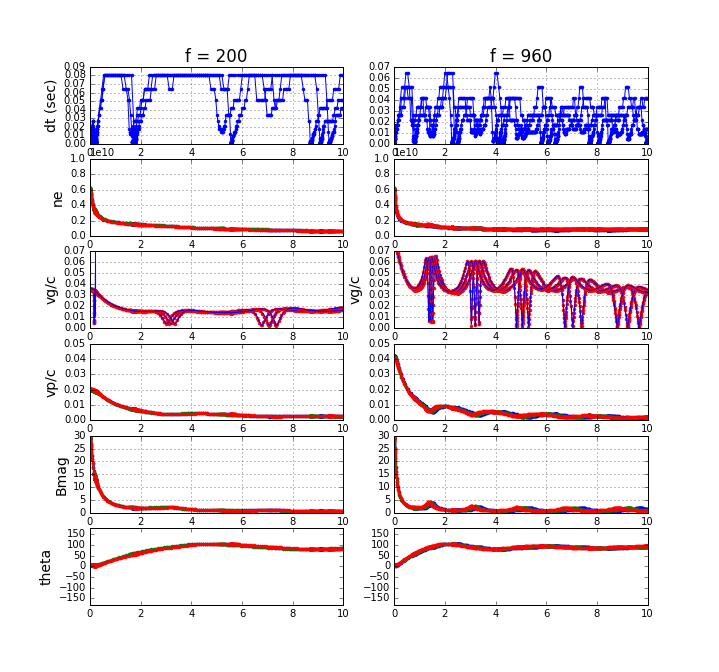

In [884]:

lat1 = 40
lat2 = 42
rf1 = read_rayfiles(rootdir,200, lat1, lat2, 0,0)
# rf2 = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_test/',400,  lat1, lat2, 0,0)
rf3 = read_rayfiles(rootdir,960,  lat1, lat2, 0,0)
# rf4 = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_test/',1000, lat1, lat2, 0,0)

rflists = [rf1, rf3]


# keys: ['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time','Nspec', 'Ns', 'vgrel']


fig, ax = plt.subplots(6,len(rflists))

tlims=[0,10]
for ind, rf in enumerate(rflists):
    for ray in rf:
        
#         # Position
#         y = np.asarray(ray['pos'])/R_E
#         x = ray['time']
#         ax[0,ind].plot(x,y[:,0],'r.-')
#         ax[0,ind].plot(x,y[:,1],'g.-')
#         ax[0,ind].plot(x,y[:,2],'b.-')
#         #ax[0,ind].set_xlabel('altitude (Re)')
#         ax[0,0].set_ylabel('r')
#         ax[0,ind].set_title('f = %g'%(ray['w']/2./np.pi))
#         ax[0,ind].grid()
#         ax[0,ind].set_xlim(tlims)
        
        y = np.diff(ray['time'])
        x = np.asarray(ray['time'])[0:-1]
        ax[0,ind].plot(x,y,'b.-')
        ax[0,0].set_ylabel('dt (sec)')
        ax[0,ind].set_title('f = %g'%(ray['w']/2./np.pi))
        ax[0,ind].grid()
        ax[0,ind].set_xlim(tlims)
        
        # Density

        x2 = ray['time']
        y2 = ray['Ns'].iloc[:,0]
        ax[1,ind].plot(x2, y2, '.-')
        ax[1,0].set_ylabel('ne')
        ax[1,ind].set_ylim([0, 1e10])
        ax[1,ind].set_xlim(tlims)
        ax[1,ind].grid()

        # Group velocity
        x3 = ray['time']
        y3 = np.linalg.norm(ray['vgrel'],axis=1)
        ax[2,ind].plot(x3, y3, "r.-")
        # calculate vg from position to confirm
        y3_c = np.linalg.norm(np.diff(ray['pos'],axis=0),axis=1)/np.diff(ray['time'])/C
        x3_c = ray['time'].iloc[1:]
        ax[2,ind].plot(x3_c,y3_c,'b')
        ax[2,ind].set_ylabel('vg/c')
        ax[2,ind].grid()
        ax[2,ind].set_ylim([0, 0.07])
        ax[2,ind].set_xlim(tlims)

        # Phase velocity
        x4 = ray['time']
        y4 = np.linalg.norm(ray['vprel'],axis=1)
        ax[3,ind].plot(x4, y4, ".-")
        ax[3,0].set_ylabel('vp/c')
        ax[3,ind].grid()
        ax[3,ind].set_ylim([0, 0.05])
        ax[3,ind].set_xlim(tlims)
        
        # B field
        x5 = ray['time']
        y5 = np.linalg.norm(ray['B0'],axis=1)*1e6
        ax[4,ind].plot(x5, y5, ".-")
        ax[4,0].set_ylabel('Bmag')
        ax[4,ind].grid()
#         ax[4,ind].set_ylim([0, 0.06])
        ax[4,ind].set_xlim(tlims)
    
        # wavenormal angle to B
        theta = np.zeros(len(ray['time']))
        for i in range(len(ray['B0'])):
            bv = np.asarray(ray['B0'].iloc[i,:])
            nv = np.asarray(ray['n'].iloc[i,:])
            theta[i] = np.arccos(-1.0*np.dot(bv, nv)/np.linalg.norm(bv)/np.linalg.norm(nv))*180./np.pi
            
    
        x6 = ray['time']
        y6 = theta
        ax[5,ind].plot(x6, y6, ".-")
        ax[5,ind].set_xlim(tlims)
        ax[5,0].set_ylabel('theta')
        ax[5,ind].set_ylim([-180, 180])

# for i in range(1, np.shape(ax)[0]):
#     for j in range(1, np.shape(ax)[1]):
#         ax[i,j].set_yticks('')


800.0
(1001,)
(1001,)


<IPython.core.display.Javascript object>


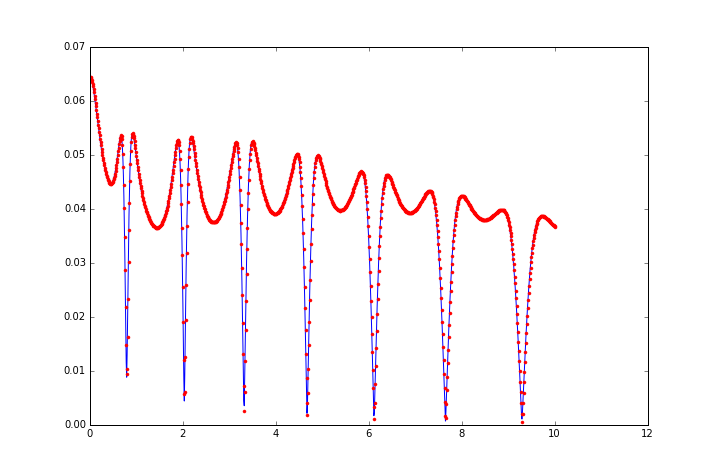

In [658]:
print ray['w']/2./np.pi
y = np.linalg.norm(np.diff(ray['pos'],axis=0),axis=1)/np.diff(ray['time'])/C
x = ray['time'].iloc[0:-1]

x2 = ray['time']
y2 = np.linalg.norm(ray['vgrel'],axis=1)
print np.shape(y)
print np.shape(x)
plt.figure()
plt.plot(x,y,'b')
plt.plot(x2,y2, 'r.')



<IPython.core.display.Javascript object>


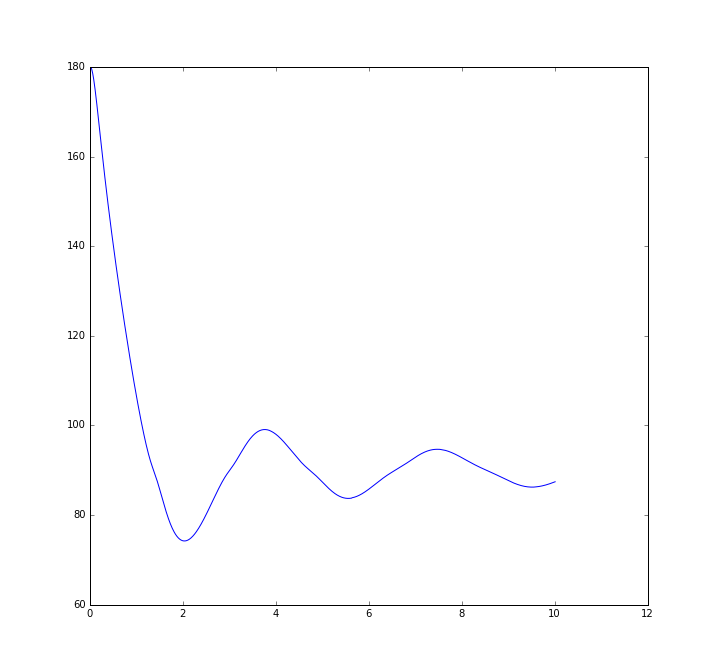

In [685]:
theta = np.zeros(len(ray['time']))
for i in range(len(ray['B0'])):
    bv = np.asarray(ray['B0'].iloc[i,:])
    nv = np.asarray(ray['n'].iloc[i,:])
    theta[i] = np.arccos(np.dot(bv, nv)/np.linalg.norm(bv)/np.linalg.norm(nv))*180./np.pi

plt.figure()
plt.plot(ray['time'],theta)

In [221]:
inp_lats = np.arange(10, 65, 1) #[40, 41, 42, 43]
inp_lons = [0, 1]
launch_alt = (R_E + 1000.)*1e3
f1 = 200; f2 = 30000;
num_freqs = 32
flogs = np.linspace(np.log10(f1), np.log10(f2), num_freqs)
freqs = np.round(pow(10, flogs)/10.)*10


print np.shape(inp_lats)
print np.shape(inp_lons)

lats, lons, ws = np.meshgrid(inp_lats, inp_lons, 2.0*np.pi*freqs)
lats = lats.flatten()
lons = lons.flatten()
ws   = ws.flatten()

alts = launch_alt*np.ones_like(lats)
alts[ws < 2*np.pi*600] += 3000e3

inps = zip(alts, lats, lons, ws)
print np.shape(inps)

(55,)
(2,)
(3520, 4)


<IPython.core.display.Javascript object>


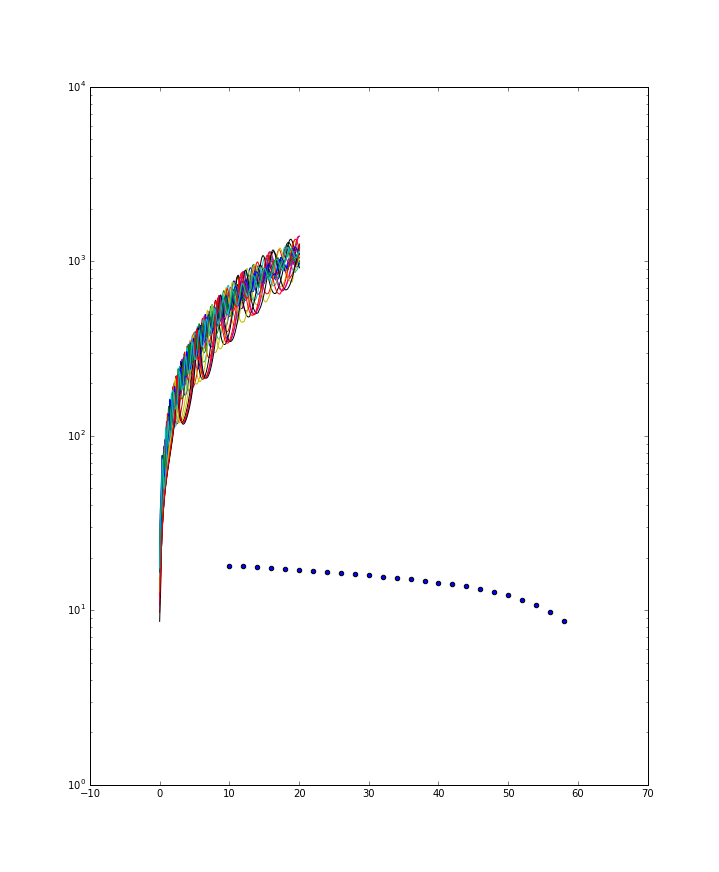

In [444]:
plt.figure()

for r in rf:
#     x = np.sqrt(np.sum(r['pos']**2,axis=1))
    x = r['time']
    y = np.sqrt(np.sum(r['n']**2,axis=1))
#     y = np.sqrt(np.sum(r['vprel']**2,axis=1))
    plt.semilogy(x,y)

<IPython.core.display.Javascript object>


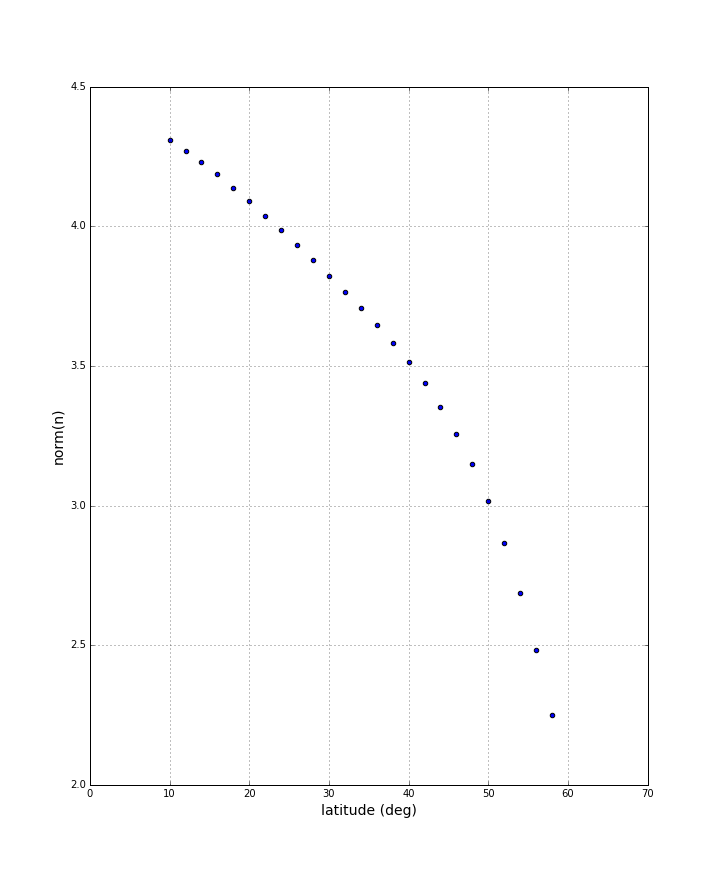

[ 34.]
[ 32.]
[ 10.]
[ 18.]
[ 24.]
[ 56.]
[ 38.]
[ 44.]
[ 46.]
[ 26.]
[ 52.]
[ 30.]
[ 42.]
[ 16.]
[ 36.]
[ 48.]
[ 22.]
[ 12.]
[ 40.]
[ 54.]
[ 58.]
[ 14.]
[ 28.]
[ 50.]
[ 20.]


In [463]:
# fvec = np.linspace(200, 2000, 100)
C = 2.998e8
flashtime = dt.datetime(2010, 6, 4, 7, 0, 0)
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks


plt.figure()
for r in rf:
    n = r['n'].iloc[0,:]
    nmag = np.linalg.norm(n)
    # Get starting latitude:
    p = r['pos'].iloc[0,:]
    tmp_coords = coord.Coords(p,'SM','car',units=['m','m','m'])
    tmp_coords.ticks = Ticktock(flashtime)
    tmp_coords = tmp_coords.convert('MAG','sph')
    lat = tmp_coords.lati
    print lat
    plt.scatter(lat, nmag)
    
plt.ylabel('norm(n)')
plt.xlabel('latitude (deg)')
plt.grid()
#     plt.plot(fvec, nmag*fvec*2.*np.pi/C)


In [294]:
# Check the electron gyrofrequency seting
((30e-6)*(1.602e-19)/(9.1e-31))/(2.*np.pi)/1000.


840.5479741754385

In [334]:
from raytracer_utils import read_damp

dampfn = '/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/f_200/lon_0/damp_200_10_0.ray'

rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/',1000, 0, 60, 0,0)

rf[0]['damping']
rf[0]['time']
# x = read_damp(dampfn)
# plt.figure()
# plt.plot(x[0]['time'], x[0]['damping'])

0       0.000000
1       0.000100
2       0.000200
3       0.000325
4       0.000481
5       0.000677
6       0.000921
7       0.001226
8       0.001607
9       0.002084
10      0.002680
11      0.003425
12      0.004357
13      0.005521
14      0.006976
15      0.008795
16      0.011069
17      0.013911
18      0.017464
19      0.021904
20      0.027456
21      0.034394
22      0.043068
23      0.053910
24      0.067463
25      0.084403
26      0.105579
27      0.132049
28      0.165136
29      0.206495
         ...    
394    27.791857
395    27.872636
396    27.953416
397    28.034195
398    28.114974
399    28.195754
400    28.260377
401    28.325001
402    28.389624
403    28.470404
404    28.551183
405    28.631962
406    28.712742
407    28.793521
408    28.874300
409    28.955080
410    29.035859
411    29.116639
412    29.197418
413    29.278197
414    29.358977
415    29.439756
416    29.520535
417    29.601315
418    29.682094
419    29.762873
420    29.827497
421    29.8921

In [711]:
dfdk= np.array([-1.993669492425781E+17, 0., -1.9874870865625E+16])
dfdw= 2.536496546396659E+11
np.linalg.norm(dfdk/dfdw/C)

dfdk= np.array([-2.9701613283203124E+16, 0., -3.772300476171875E+15])
dfdw= 2.6842196883417816E+9
np.linalg.norm(dfdk/dfdw/C)

0.037205327669608802

In [ ]:
rootdir = '/shared/users/asousa/WIPP/3dWIPP/outputs/fl_ngo_igrf2/'

import re

# Get all available frequencies, lats, and lons:
d = os.listdir(rootdir)
freqs =[ int(name[3:]) for name in os.listdir(rootdir) 
        if os.path.isdir(os.path.join(rootdir, name)) 
        and name.startswith('f_')]
print freqs

entries = []
for root, path, name in os.walk(rootdir):
    entries.extend([n[0:-4].split("_")[1:] for n in name if n.startswith("ray_") and n.endswith(".ray")])

In [42]:
print np.shape(entries)
entries = np.array(entries,dtype='float64')

frqs = np.unique(entries[:,0])
lats = np.unique(entries[:,1])
lons = np.unique(entries[:,2])



(18150, 3)
[   200.    230.    270.    320.    370.    440.    510.    600.    700.
    820.    960.   1120.   1310.   1530.   1790.   2090.   2450.   2860.
   3350.   3920.   4580.   5360.   6270.   7330.   8570.  10030.  11720.
  13710.  16040.  18750.  21930.  25650.  30000.]
[ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
